### 모델 로드

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class MultiFolderSegmentationDataset(Dataset):
    def __init__(self, root_dir, folders, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.label_paths = []

        # 폴더별 이미지 및 라벨 파일 경로 생성
        for folder in folders:
            tensor_folder = folder + "_tensors_256x256(7 classes)"
            image_folder_path = os.path.join(root_dir, folder)
            tensor_folder_path = os.path.join(root_dir, tensor_folder)

            if not os.path.exists(tensor_folder_path):
                raise ValueError(f"Matching tensor folder not found for {folder}")

            for img_name in sorted(os.listdir(image_folder_path)):
                if not img_name.endswith(".jpg"):
                    continue  # JPG 파일만 처리

                image_path = os.path.join(image_folder_path, img_name)
                label_path = os.path.join(tensor_folder_path, os.path.splitext(img_name)[0] + "_mask.pt")

                if not os.path.exists(label_path):
                    raise ValueError(f"Missing tensor file for {img_name} in {tensor_folder_path}")

                self.image_paths.append(image_path)
                self.label_paths.append(label_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 이미지 및 라벨 경로
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # 이미지와 라벨 데이터 로드
        image = Image.open(image_path).convert("RGB")
        label = torch.load(label_path,weights_only=True)# .pt 텐서 로드 (256x256 크기)
        label=label.to(torch.int64)

        if self.transform:
            image = self.transform(image)

        return image, label

# 상위 디렉토리 경로
root_dir = "/home/dongju/캡스톤디자인2"

# train과 val에 사용할 폴더 지정
train_folders = ["Surface_1", "Surface_2", "Surface_3", "Surface_4"]
val_folders = ["Surface_5"]

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet 통계
])


# train 데이터셋 및 데이터 로더
train_dataset = MultiFolderSegmentationDataset(root_dir, train_folders, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# val 데이터셋 및 데이터 로더
val_dataset = MultiFolderSegmentationDataset(root_dir, val_folders, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# 데이터 로더 확인
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print("=======================================================================")

# 데이터 로더 사용 예시
for images, labels in train_dataloader:
    print("Train image batch:", images.shape)
    print("Train label shape:",labels.shape)
    print("=======================================================================")
    break

for images, labels in val_dataloader:
    print("Validation imgage batch:", images.shape)
    print("Validation label shape:",labels.shape)
    break


Train dataset size: 37607
Validation dataset size: 8792
Train image batch: torch.Size([64, 3, 256, 256])
Train label shape: torch.Size([64, 256, 256])
Validation imgage batch: torch.Size([64, 3, 256, 256])
Validation label shape: torch.Size([64, 256, 256])


### 모델코드

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large

# Squeeze-and-Excitation 모듈 정의
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SqueezeExcitation, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        se = F.adaptive_avg_pool2d(x, 1).view(b, c)
        se = F.relu(self.fc1(se))
        se = torch.sigmoid(self.fc2(se)).view(b, c, 1, 1)
        return x * se

# Lightweight ASPP 모듈
class LightweightASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LightweightASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3, dilation=3)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.conv_out = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x))
        x3 = F.relu(self.conv3(x))

        # Global context
        x4 = self.global_avg_pool(x)
        x4 = F.relu(self.global_conv(x4))
        x4 = F.interpolate(x4, size=x1.size()[2:], mode='bilinear', align_corners=False)

        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.conv_out(x)
        x = self.dropout(x)
        return x

# MobileNetV3 기반 DeepLabV3 모델 정의
class MobileNetV3DeepLabV3(nn.Module):
    def __init__(self, num_classes=8):
        super(MobileNetV3DeepLabV3, self).__init__()

        # MobileNetV3 Large 백본 정의
        mobilenet_v3_model = mobilenet_v3_large(pretrained=True)
        self.backbone = mobilenet_v3_model.features

        # 다운샘플링 비율을 줄이기 위해 마지막 단계의 stride 수정
        # 마지막 레이어가 Conv2dNormActivation이므로 직접 접근하여 stride를 변경합니다.
        for module in self.backbone[::-1]:
            if isinstance(module, nn.Conv2d):
                if module.kernel_size == (1, 1):
                    module.stride = (1, 1)
                    break

        # ASPP 모듈
        self.aspp = LightweightASPP(in_channels=960, out_channels=256)

        # Squeeze-and-Excitation 모듈 추가
        self.se = SqueezeExcitation(256)

        # 최종 출력 레이어
        self.classifier = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x_size = x.size()[2:]

        # MobileNetV3 백본을 사용하여 특징 추출
        x = self.backbone(x)

        # ASPP 모듈 적용
        x = self.aspp(x)

        # Squeeze-and-Excitation 모듈 적용
        x = self.se(x)

        # 클래스 점수 계산
        x = self.classifier(x)

        # 원본 이미지 크기로 업샘플링
        x = F.interpolate(x, size=x_size, mode='bilinear', align_corners=False)
        return x

# 모델 생성 및 장치 설정
num_classes = 8  # 배경을 포함한 총 8개 클래스
model = MobileNetV3DeepLabV3(num_classes=num_classes)

# 모델을 GPU 또는 CPU에 할당
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/home/dongju/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dongju/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 함수 정의

In [3]:
import torch
import os
import csv
import numpy as np
from tqdm import tqdm

# 클래스 이름 (배경 제외)
CLASS_NAMES_NO_BG = ["Sidewalk", "Braille Guide Blocks", "Roadway", "Alley", "Bike Lane", "Caution Zone", "Cross walk"]

# 배치별 메트릭을 CSV로 저장하는 함수 (배경 제외)
def save_batch_metrics_to_csv(epoch, phase, batch_loss, batch_iou, pixel_acc, class_iou, filename="batch_metrics.csv"):
    """
    배치별 메트릭을 하나의 CSV 파일에 저장
    :param epoch: 현재 에폭
    :param phase: "train" 또는 "val"로 단계 표시
    :param batch_loss: 배치 Loss
    :param batch_iou: 배치 IoU
    :param pixel_acc: 픽셀 정확도
    :param class_iou: 클래스별 IoU 리스트
    :param filename: 저장할 CSV 파일 이름
    """
    try:
        file_exists = os.path.isfile(filename)
        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            # 파일이 없으면 헤더 추가
            if not file_exists:
                header = ["epoch", "phase", "batch_loss", "batch_iou", "pixel_acc"] + [f"iou_{name}" for name in CLASS_NAMES_NO_BG]
                writer.writerow(header)
            # 배치 데이터 저장
            row = [epoch, phase, batch_loss, batch_iou, pixel_acc] + (class_iou.tolist() if phase == "val" else [""] * len(CLASS_NAMES_NO_BG))
            writer.writerow(row)
    except Exception as e:
        print(f"Failed to save batch metrics to CSV: {e}")

# 에폭 단위 메트릭을 CSV로 저장하는 함수 (배경 제외)
def save_epoch_metrics_to_csv(epoch, phase, epoch_loss, epoch_iou, pixel_acc, class_iou, filename="epoch_metrics.csv"):
    """
    에폭 단위 메트릭을 하나의 CSV 파일에 저장
    :param epoch: 현재 에폭
    :param phase: "train" 또는 "val"로 단계 표시
    :param epoch_loss: 에폭 평균 Loss
    :param epoch_iou: 에폭 평균 IoU
    :param pixel_acc: 픽셀 정확도
    :param class_iou: 클래스별 IoU 리스트
    :param filename: 저장할 CSV 파일 이름
    """
    try:
        file_exists = os.path.isfile(filename)
        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            # 파일이 없으면 헤더 추가
            if not file_exists:
                header = ["epoch", "phase", "epoch_loss", "epoch_iou", "pixel_acc"] + [f"iou_{name}" for name in CLASS_NAMES_NO_BG]
                writer.writerow(header)
            # 에폭 데이터 저장
            row = [epoch, phase, epoch_loss, epoch_iou, pixel_acc] + class_iou.tolist()
            writer.writerow(row)
    except Exception as e:
        print(f"Failed to save epoch metrics to CSV: {e}")

# 클래스별 IoU 계산 (배경 제외 가능)
def calculate_iou_per_class(pred, target, num_classes, exclude_background=True):
    iou_per_class = torch.zeros(num_classes, dtype=torch.float32)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            iou_per_class[cls] = 0.0
        else:
            iou_per_class[cls] = intersection / union

    # 배경을 제외하고 나머지 클래스 IoU만 반환
    if exclude_background:
        return iou_per_class[1:]

    return iou_per_class

# 픽셀 정확도 계산
def calculate_pixel_accuracy(pred, target):
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

# 모델 학습 및 검증 함수
def train_model_with_csv_and_checkpoint(
    model, train_dataloader, val_dataloader, criterion, optimizer, 
    num_classes, num_epochs=25, device='cuda:0', csv_filename="metrics.csv", 
    checkpoint_dir="./checkpoints", checkpoint_file=None, batch_csv_filename="batch_metrics.csv", 
    epoch_csv_filename="epoch_metrics.csv"
):
    os.makedirs(checkpoint_dir, exist_ok=True)
    model.to(device)
    print(f"Model device: {next(model.parameters()).device}")

    start_epoch = 0

    # 체크포인트 로드
    if checkpoint_file and os.path.isfile(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch + 1}.")
    else:
        print("No checkpoint found. Starting training from scratch.")
    
    # 학습 루프
    for epoch in range(start_epoch + 1, start_epoch + num_epochs + 1):
        print(f"\nEpoch {epoch}/{start_epoch + num_epochs}")

        # 학습 단계
        model.train()
        train_loss = []
        train_iou = []
        train_pixel_acc = []

        train_loader = tqdm(train_dataloader, desc=f"Train Epoch {epoch}", leave=False)
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            outputs = torch.argmax(outputs, dim=1)
            batch_loss = loss.item()
            batch_iou = calculate_iou_per_class(outputs, masks, num_classes, exclude_background=True).mean().item()
            pixel_acc = calculate_pixel_accuracy(outputs, masks)

            train_loss.append(batch_loss)
            train_iou.append(batch_iou)
            train_pixel_acc.append(pixel_acc)

            # 배치 데이터를 CSV에 저장
            save_batch_metrics_to_csv(epoch, "train", batch_loss, batch_iou, pixel_acc, [], filename=batch_csv_filename)

        # 에폭 평균 계산
        epoch_train_loss = np.mean(train_loss)
        epoch_train_iou = np.mean(train_iou)
        epoch_train_pixel_acc = np.mean(train_pixel_acc)

        # 에폭 데이터를 CSV에 저장
        save_epoch_metrics_to_csv(epoch, "train", epoch_train_loss, epoch_train_iou, epoch_train_pixel_acc, torch.zeros(num_classes - 1), filename=epoch_csv_filename)

        # 검증 단계
        model.eval()
        val_loss = []
        val_iou = []
        val_pixel_acc = []
        class_iou = torch.zeros(num_classes - 1)  # 배경 제외한 클래스 개수로 초기화

        val_loader = tqdm(val_dataloader, desc="Validation", leave=False)
        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(val_loader):
                images, masks = images.to(device), masks.long().to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                outputs = torch.argmax(outputs, dim=1)
                batch_loss = loss.item()
                class_iou_batch = calculate_iou_per_class(outputs, masks, num_classes, exclude_background=True)
                batch_iou = class_iou_batch.mean().item()
                pixel_acc = calculate_pixel_accuracy(outputs, masks)

                val_loss.append(batch_loss)
                val_iou.append(batch_iou)
                val_pixel_acc.append(pixel_acc)
                class_iou += class_iou_batch

                # 배치 데이터를 CSV에 저장
                save_batch_metrics_to_csv(epoch, "val", batch_loss, batch_iou, pixel_acc, class_iou_batch, filename=batch_csv_filename)

        # 에폭 평균 계산
        epoch_val_loss = np.mean(val_loss)
        epoch_val_iou = np.mean(val_iou)
        epoch_val_pixel_acc = np.mean(val_pixel_acc)
        class_iou /= len(val_loader)  # 평균 IoU 계산

        # 에폭 데이터를 CSV에 저장
        save_epoch_metrics_to_csv(epoch, "val", epoch_val_loss, epoch_val_iou, epoch_val_pixel_acc, class_iou, filename=epoch_csv_filename)

        # 에폭 종료 시 모델 체크포인트 저장
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)

        print(f"Checkpoint saved to {checkpoint_path}")

        # 최종 결과 출력 (배경 제외)
        print("\n========================= Epoch Results =========================")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train mIoU: {epoch_train_iou:.4f}")
        print(f"Val Loss:   {epoch_val_loss:.4f}, Val mIoU:   {epoch_val_iou:.4f}")
        print(f"Class-wise Val IoU:")
        for idx, iou in enumerate(class_iou.tolist()):
            print(f"  {CLASS_NAMES_NO_BG[idx]}: {iou:.4f}")
        print("================================================================")


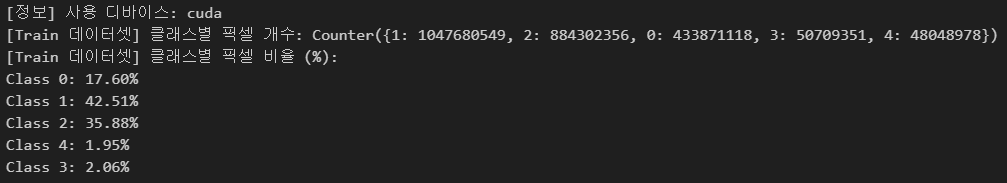

### 학습 호출

In [ ]:
import torch.optim as optim

# CUDA 환경 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# 모델 및 학습 설정
num_classes = 8 # 실제 학습할 클래스 수 (
learning_rate = 0.00001
weight_decay = 0.00001
num_epochs = 10

# 모델, 옵티마이저, 손실 함수 설정
model = MobileNetV3DeepLabV3(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 손실 함수 및 장치 설정 (가중치 없이)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 손실 함수 설정
criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)


# 기존 학습 코드 실행 (CSV 파일 두 개 지정)
train_model_with_csv_and_checkpoint(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_classes=num_classes,
    num_epochs=num_epochs,
    device=device,
    batch_csv_filename="./64_batch_metrics.csv",  # 배치 단위 메트릭
    epoch_csv_filename="./64_epoch_metrics.csv",  # 에폭 단위 메트릭
    checkpoint_dir="./64_batch_metrics_checkpoints",
    checkpoint_file=None
)





Model device: cuda:0
No checkpoint found. Starting training from scratch.

Epoch 1/10


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_1.pth

========================= Epoch Results =========================
Train Loss: 0.9148, Train mIoU: 0.2888
Val Loss:   0.6210, Val mIoU:   0.3638
Class-wise Val IoU:
  Sidewalk: 0.7127
  Braille Guide Blocks: 0.1392
  Roadway: 0.2024
  Alley: 0.7349
  Bike Lane: 0.1340
  Caution Zone: 0.4755
  Cross walk: 0.1483

Epoch 2/10


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_2.pth

========================= Epoch Results =========================
Train Loss: 0.5280, Train mIoU: 0.3838
Val Loss:   0.4733, Val mIoU:   0.4111
Class-wise Val IoU:
  Sidewalk: 0.7253
  Braille Guide Blocks: 0.1730
  Roadway: 0.2559
  Alley: 0.7496
  Bike Lane: 0.1708
  Caution Zone: 0.5416
  Cross walk: 0.2613

Epoch 3/10


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_3.pth

========================= Epoch Results =========================
Train Loss: 0.4322, Train mIoU: 0.4153
Val Loss:   0.4057, Val mIoU:   0.4341
Class-wise Val IoU:
  Sidewalk: 0.7305
  Braille Guide Blocks: 0.2257
  Roadway: 0.2700
  Alley: 0.7534
  Bike Lane: 0.1853
  Caution Zone: 0.5610
  Cross walk: 0.3129

Epoch 4/10


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_4.pth

========================= Epoch Results =========================
Train Loss: 0.3776, Train mIoU: 0.4328
Val Loss:   0.3805, Val mIoU:   0.4521
Class-wise Val IoU:
  Sidewalk: 0.7333
  Braille Guide Blocks: 0.2737
  Roadway: 0.2768
  Alley: 0.7537
  Bike Lane: 0.1875
  Caution Zone: 0.5901
  Cross walk: 0.3497

Epoch 5/10


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_5.pth

========================= Epoch Results =========================
Train Loss: 0.3389, Train mIoU: 0.4525
Val Loss:   0.3588, Val mIoU:   0.4639
Class-wise Val IoU:
  Sidewalk: 0.7318
  Braille Guide Blocks: 0.3084
  Roadway: 0.2892
  Alley: 0.7615
  Bike Lane: 0.1901
  Caution Zone: 0.5997
  Cross walk: 0.3666

Epoch 6/10


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_6.pth

========================= Epoch Results =========================
Train Loss: 0.3093, Train mIoU: 0.4661
Val Loss:   0.3474, Val mIoU:   0.4773
Class-wise Val IoU:
  Sidewalk: 0.7296
  Braille Guide Blocks: 0.3693
  Roadway: 0.2876
  Alley: 0.7572
  Bike Lane: 0.2020
  Caution Zone: 0.6078
  Cross walk: 0.3873

Epoch 7/10


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_7.pth

========================= Epoch Results =========================
Train Loss: 0.2821, Train mIoU: 0.4828
Val Loss:   0.3416, Val mIoU:   0.4810
Class-wise Val IoU:
  Sidewalk: 0.7305
  Braille Guide Blocks: 0.3854
  Roadway: 0.2808
  Alley: 0.7611
  Bike Lane: 0.2072
  Caution Zone: 0.5996
  Cross walk: 0.4025

Epoch 8/10


Train Epoch 8:  71%|███████▏  | 420/588 [05:13<01:47,  1.56it/s]

In [4]:
import torch.optim as optim

# CUDA 환경 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# 모델 및 학습 설정
num_classes = 8 # 실제 학습할 클래스 수 (
learning_rate = 0.000005
weight_decay = 0.000005
num_epochs = 5

# 모델, 옵티마이저, 손실 함수 설정
model = MobileNetV3DeepLabV3(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 손실 함수 및 장치 설정 (가중치 없이)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 손실 함수 설정
criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)


# 기존 학습 코드 실행 (CSV 파일 두 개 지정)
train_model_with_csv_and_checkpoint(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_classes=num_classes,
    num_epochs=num_epochs,
    device=device,
    batch_csv_filename="./64_batch_metrics.csv",  # 배치 단위 메트릭
    epoch_csv_filename="./64_epoch_metrics.csv",  # 에폭 단위 메트릭
    checkpoint_dir="./64_batch_metrics_checkpoints",
    checkpoint_file="./64_batch_metrics_checkpoints/model_epoch_7.pth"
)





/home/dongju/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dongju/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_3380208/2606396079.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Model device: cuda:0
Resuming training from epoch 8.

Epoch 8/12


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_8.pth

========================= Epoch Results =========================
Train Loss: 0.2573, Train mIoU: 0.4949
Val Loss:   0.3486, Val mIoU:   0.4874
Class-wise Val IoU:
  Sidewalk: 0.7200
  Braille Guide Blocks: 0.4135
  Roadway: 0.2924
  Alley: 0.7646
  Bike Lane: 0.2187
  Caution Zone: 0.6088
  Cross walk: 0.3935

Epoch 9/12


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_9.pth

========================= Epoch Results =========================
Train Loss: 0.2344, Train mIoU: 0.5102
Val Loss:   0.3552, Val mIoU:   0.4900
Class-wise Val IoU:
  Sidewalk: 0.7164
  Braille Guide Blocks: 0.4301
  Roadway: 0.3008
  Alley: 0.7613
  Bike Lane: 0.2186
  Caution Zone: 0.6066
  Cross walk: 0.3961

Epoch 10/12


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_10.pth

========================= Epoch Results =========================
Train Loss: 0.2133, Train mIoU: 0.5252
Val Loss:   0.3574, Val mIoU:   0.4936
Class-wise Val IoU:
  Sidewalk: 0.7238
  Braille Guide Blocks: 0.4629
  Roadway: 0.2873
  Alley: 0.7611
  Bike Lane: 0.2270
  Caution Zone: 0.6041
  Cross walk: 0.3894

Epoch 11/12


KeyboardInterrupt: 

In [4]:
import torch.optim as optim

# CUDA 환경 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# 모델 및 학습 설정
num_classes = 8 # 실제 학습할 클래스 수 (
learning_rate = 0.000001
weight_decay = 0.000001
num_epochs = 5

# 모델, 옵티마이저, 손실 함수 설정
model = MobileNetV3DeepLabV3(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 손실 함수 및 장치 설정 (가중치 없이)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 손실 함수 설정
criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)


# 기존 학습 코드 실행 (CSV 파일 두 개 지정)
train_model_with_csv_and_checkpoint(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_classes=num_classes,
    num_epochs=num_epochs,
    device=device,
    batch_csv_filename="./64_batch_metrics.csv",  # 배치 단위 메트릭
    epoch_csv_filename="./64_epoch_metrics.csv",  # 에폭 단위 메트릭
    checkpoint_dir="./64_batch_metrics_checkpoints",
    checkpoint_file="./64_batch_metrics_checkpoints/model_epoch_10.pth"
)





/tmp/ipykernel_3630478/2606396079.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Model device: cuda:0
Resuming training from epoch 11.

Epoch 11/15


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_11.pth

========================= Epoch Results =========================
Train Loss: 0.1931, Train mIoU: 0.5386
Val Loss:   0.3652, Val mIoU:   0.4976
Class-wise Val IoU:
  Sidewalk: 0.7241
  Braille Guide Blocks: 0.4829
  Roadway: 0.2774
  Alley: 0.7618
  Bike Lane: 0.2242
  Caution Zone: 0.6055
  Cross walk: 0.4071

Epoch 12/15


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_12.pth

========================= Epoch Results =========================
Train Loss: 0.1777, Train mIoU: 0.5512
Val Loss:   0.3756, Val mIoU:   0.5016
Class-wise Val IoU:
  Sidewalk: 0.7174
  Braille Guide Blocks: 0.4948
  Roadway: 0.2889
  Alley: 0.7649
  Bike Lane: 0.2251
  Caution Zone: 0.6116
  Cross walk: 0.4084

Epoch 13/15


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_13.pth

========================= Epoch Results =========================
Train Loss: 0.1613, Train mIoU: 0.5645
Val Loss:   0.3816, Val mIoU:   0.5017
Class-wise Val IoU:
  Sidewalk: 0.7190
  Braille Guide Blocks: 0.5203
  Roadway: 0.2771
  Alley: 0.7536
  Bike Lane: 0.2373
  Caution Zone: 0.6094
  Cross walk: 0.3951

Epoch 14/15


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_14.pth

========================= Epoch Results =========================
Train Loss: 0.1499, Train mIoU: 0.5719
Val Loss:   0.3944, Val mIoU:   0.5088
Class-wise Val IoU:
  Sidewalk: 0.7097
  Braille Guide Blocks: 0.5373
  Roadway: 0.2963
  Alley: 0.7572
  Bike Lane: 0.2525
  Caution Zone: 0.6135
  Cross walk: 0.3952

Epoch 15/15


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_15.pth

========================= Epoch Results =========================
Train Loss: 0.1389, Train mIoU: 0.5832
Val Loss:   0.3993, Val mIoU:   0.5056
Class-wise Val IoU:
  Sidewalk: 0.7150
  Braille Guide Blocks: 0.5494
  Roadway: 0.2736
  Alley: 0.7568
  Bike Lane: 0.2437
  Caution Zone: 0.6065
  Cross walk: 0.3947


In [5]:
import torch.optim as optim

# CUDA 환경 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# 모델 및 학습 설정
num_classes = 8 # 실제 학습할 클래스 수 (
learning_rate = 0.00001
weight_decay = 0.00001
num_epochs = 10

# 모델, 옵티마이저, 손실 함수 설정
model = MobileNetV3DeepLabV3(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 손실 함수 및 장치 설정 (가중치 없이)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 손실 함수 설정
criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)


# 기존 학습 코드 실행 (CSV 파일 두 개 지정)
train_model_with_csv_and_checkpoint(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_classes=num_classes,
    num_epochs=num_epochs,
    device=device,
    batch_csv_filename="./64_batch_metrics.csv",  # 배치 단위 메트릭
    epoch_csv_filename="./64_epoch_metrics.csv",  # 에폭 단위 메트릭
    checkpoint_dir="./64_batch_metrics_checkpoints",
    checkpoint_file="./64_batch_metrics_checkpoints/model_epoch_13.pth"
)





/tmp/ipykernel_3630478/2606396079.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Model device: cuda:0
Resuming training from epoch 14.

Epoch 14/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_14.pth

========================= Epoch Results =========================
Train Loss: 0.1506, Train mIoU: 0.5728
Val Loss:   0.3907, Val mIoU:   0.5058
Class-wise Val IoU:
  Sidewalk: 0.7183
  Braille Guide Blocks: 0.5357
  Roadway: 0.2869
  Alley: 0.7555
  Bike Lane: 0.2379
  Caution Zone: 0.6071
  Cross walk: 0.3995

Epoch 15/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_15.pth

========================= Epoch Results =========================
Train Loss: 0.1387, Train mIoU: 0.5841
Val Loss:   0.3987, Val mIoU:   0.5089
Class-wise Val IoU:
  Sidewalk: 0.7145
  Braille Guide Blocks: 0.5539
  Roadway: 0.2785
  Alley: 0.7556
  Bike Lane: 0.2438
  Caution Zone: 0.6143
  Cross walk: 0.4013

Epoch 16/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_16.pth

========================= Epoch Results =========================
Train Loss: 0.1295, Train mIoU: 0.5906
Val Loss:   0.4082, Val mIoU:   0.5111
Class-wise Val IoU:
  Sidewalk: 0.7171
  Braille Guide Blocks: 0.5672
  Roadway: 0.2817
  Alley: 0.7586
  Bike Lane: 0.2400
  Caution Zone: 0.6164
  Cross walk: 0.3968

Epoch 17/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_17.pth

========================= Epoch Results =========================
Train Loss: 0.1211, Train mIoU: 0.5986
Val Loss:   0.4259, Val mIoU:   0.5095
Class-wise Val IoU:
  Sidewalk: 0.7176
  Braille Guide Blocks: 0.5751
  Roadway: 0.2809
  Alley: 0.7440
  Bike Lane: 0.2407
  Caution Zone: 0.6108
  Cross walk: 0.3977

Epoch 18/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_18.pth

========================= Epoch Results =========================
Train Loss: 0.1148, Train mIoU: 0.6041
Val Loss:   0.4254, Val mIoU:   0.5125
Class-wise Val IoU:
  Sidewalk: 0.7143
  Braille Guide Blocks: 0.5795
  Roadway: 0.2834
  Alley: 0.7540
  Bike Lane: 0.2424
  Caution Zone: 0.6161
  Cross walk: 0.3981

Epoch 19/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_19.pth

========================= Epoch Results =========================
Train Loss: 0.1074, Train mIoU: 0.6108
Val Loss:   0.4286, Val mIoU:   0.5153
Class-wise Val IoU:
  Sidewalk: 0.7128
  Braille Guide Blocks: 0.5840
  Roadway: 0.2930
  Alley: 0.7529
  Bike Lane: 0.2481
  Caution Zone: 0.6171
  Cross walk: 0.3990

Epoch 20/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_20.pth

========================= Epoch Results =========================
Train Loss: 0.1029, Train mIoU: 0.6160
Val Loss:   0.4467, Val mIoU:   0.5112
Class-wise Val IoU:
  Sidewalk: 0.7205
  Braille Guide Blocks: 0.5926
  Roadway: 0.2689
  Alley: 0.7522
  Bike Lane: 0.2432
  Caution Zone: 0.6114
  Cross walk: 0.3895

Epoch 21/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_21.pth

========================= Epoch Results =========================
Train Loss: 0.0974, Train mIoU: 0.6176
Val Loss:   0.4472, Val mIoU:   0.5161
Class-wise Val IoU:
  Sidewalk: 0.7174
  Braille Guide Blocks: 0.5990
  Roadway: 0.2848
  Alley: 0.7557
  Bike Lane: 0.2402
  Caution Zone: 0.6126
  Cross walk: 0.4029

Epoch 22/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_22.pth

========================= Epoch Results =========================
Train Loss: 0.0937, Train mIoU: 0.6248
Val Loss:   0.4624, Val mIoU:   0.5130
Class-wise Val IoU:
  Sidewalk: 0.7150
  Braille Guide Blocks: 0.6011
  Roadway: 0.2794
  Alley: 0.7535
  Bike Lane: 0.2411
  Caution Zone: 0.6114
  Cross walk: 0.3897

Epoch 23/23


Checkpoint saved to ./64_batch_metrics_checkpoints/model_epoch_23.pth

========================= Epoch Results =========================
Train Loss: 0.0889, Train mIoU: 0.6275
Val Loss:   0.4562, Val mIoU:   0.5171
Class-wise Val IoU:
  Sidewalk: 0.7106
  Braille Guide Blocks: 0.5926
  Roadway: 0.2851
  Alley: 0.7556
  Bike Lane: 0.2514
  Caution Zone: 0.6204
  Cross walk: 0.4036


### epoch 12꺼가 제일 베스트!